# Torch Vision
The `torchvision` package consists of popular datasets, model architectures, and common image transformations for computer vision.
## Loading the datasets
Loading the datasets is pretty much the same explained in [the PyTorch basics notebook](.Pytorch-Basics.ipynb).

For the sake of this example I'll be using the prebuilt dataset, because our dataset, doesn't have that much element to work with.

In [1]:
#importing the libs
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

#Loading the data
training_data = datasets.FashionMNIST(
    root="data", #Path to the data
    train=True, #Are the data for training
    download=True, #Download the data if they don't exist
    transform=ToTensor() #Transform the feature and label into tensors
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

print(f"A sample of our data consists of {len(test_data[0])} parts, the first part being the image itself as a tensor \
is of the following shape '{test_data[0][0].shape}', while the oher part is an integer refering to the label.")

A sample of our data consists of 2 parts, the first part being the image itself as a tensor is of the following shape 'torch.Size([1, 28, 28])', while the oher part is an integer refering to the label.


## Visualizing the dataset
Visualizing the datasets is pretty much the same explained in [the PyTorch basics notebook](.Pytorch-Basics.ipynb).

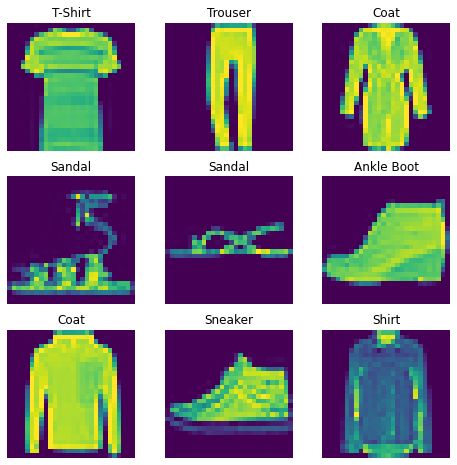

In [2]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    #print(img.shape)
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

## Transforming and augmenting images
Transforms are common image transformations available in the torchvision.transforms module. They can be chained together using Compose. Most transform classes have a function equivalent: functional transforms give fine-grained control over the transformations. This is useful if you have to build a more complex transformation pipeline (e.g. in the case of segmentation tasks).

Most transformations accept both PIL images and tensor images, although some transformations are PIL-only and some are tensor-only. The Conversion Transforms may be used to convert to and from PIL images.

The transformations that accept tensor images also accept batches of tensor images. A Tensor Image is a tensor with (C, H, W) shape, where C is a number of channels (which is one for gray and 3 for RGB images), H and W are image height and width. A batch of Tensor Images is a tensor of (B, C, H, W) shape, where B is a number of images in the batch.

Randomized transformations will apply the same transformation to all the images of a given batch, but they will produce different transformations across calls.

### Scriptable transforms
In order to script the transformations we use `torch.nn.Sequential`, it's also important to use only scriptable transformations, i.e. that work with `torch.Tensor` and does not require lambda functions or `PIL.Image`.

In the example below I've coded the transformations that I mostly use, you can find more transformations [here](https://pytorch.org/vision/stable/transforms.html).

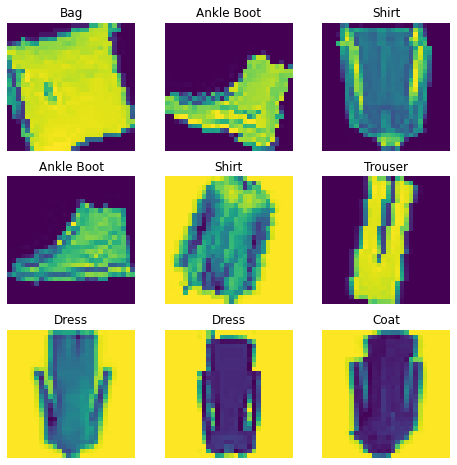

In [3]:
import torch
from torchvision import transforms

#Building the Augemntationscript as a sequence of diffrent augmentations
transform = torch.nn.Sequential(
    transforms.RandomVerticalFlip(0.5), #Would vertically flip the image with a probability of 50%
    transforms.RandomAdjustSharpness(0.5), #Would adjust the sharpness image with a probability of 50%
    transforms.RandomHorizontalFlip(0.5), #Would horizontally flip the image with a probability of 50%
    transforms.RandomRotation(20), #Doing a random 20 degree rotation.
    transforms.RandomInvert(0.5), #Inverting the image with a probability
)
scripted_transforms = torch.jit.script(transform) #Trning the aug. seq into a script.

#Visualizing an example of the augmentation results
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    img = scripted_transforms(img)
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

## Neural networks for computer vision
### Convolutional Neural Networks (CNN)
The primary difference between CNN and any other ordinary neural network is that CNN takes input as a two-dimensional array and operates directly on the images rather than focusing on feature extraction which other neural networks focus on.

The dominant approach of CNN includes solution for problems of recognition.

Every convolutional neural network includes three basic ideas:
- **Local respective fields**: CNN utilize spatial correlations that exist within the input data. Each in the concurrent layers of neural networks connects of some input neurons. This specific region is called Local Receptive Field. It only focuses on hidden neurons. The hidden neuron will process the input data inside the mentioned field not realizing the changes outside the specific boundary.
- **Convolution**: In the above figure, we observe that each connection learns a weight of hidden neuron with an associated connection with movement from one layer to another. Here, individual neurons perform a shift from time to time. This process is called “convolution”. The mapping of connections from the input layer to the hidden feature map is defined as “shared weights” and bias included is called “shared bias”.
- **Pooling**: Convolutional neural networks use pooling layers which are positioned immediately after CNN declaration. It takes the input from the user as a feature map which comes out convolutional networks and prepares a condensed feature map. Pooling layers help in creating layers with neurons of previous layers.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

device = "cuda" if torch.has_cuda else "cpu"

class CNN_Classification_Net(nn.Module):
    def __init__(self, num_classes, input_shape) -> None:
        super(CNN_Classification_Net,self).__init__()

        # first convolution layer + activation + max pooling (first layer it to capture the edges)
        self.conv1 = nn.Conv2d(in_channels = input_shape[0], out_channels = 20,
                                kernel_size=(5, 5)) #Resulting tensor size (20,24,24)
        self.act1 = nn.ReLU()#Keeping in mind that both ReLU and Pooling are doing the same thing (max(f(x),f(x2)) = f(max(x1,x2))) so the order doesn't matter.
        self.pool1 = nn.MaxPool2d(kernel_size= 2) #Resulting tensor size (20,12,12)
        self.bn1 = nn.BatchNorm2d(num_features = 20) #Batch normalization

        # second convolution layer + activation + max pooling (Second layer is for blobs and sphirical shapes)
        self.conv2 = nn.Conv2d(in_channels = 20, out_channels = 50, 
                                kernel_size = (5, 5)) #Resulting tensor (50,8,8)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size = 2) #Resulting tensor (50,4,4)
        self.bn2 = nn.BatchNorm2d(num_features = 50) #Batch normalization

        # first linear layer + activation
        self.conv_output_len = (50*4*4)
        self.linear1 = nn.Linear(in_features = self.conv_output_len, out_features = 120)
        self.act3 = nn.ReLU()
        
        # second linear layer + activation
        self.linear2 = nn.Linear(in_features = 120, out_features = 60)
        self.act4 = nn.ReLU()

        # final linear layer to produce the correct number of outputs
        self.out = nn.Linear(in_features = 60, out_features = num_classes)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # perform convolution -> activation -> pooling
        x = self.bn1(self.pool1(self.act1(self.conv1(x))))
        x = self.bn2(self.pool2(self.act2(self.conv2(x))))

        # flatten the features obtained from the conv layers: (BATCH_SIZE, 50, 4, 4) -> (BATCH_SIZE, 50*4*4=800)
        batch_size = x.shape[0]
        x = x.view(batch_size, self.conv_output_len)
        # final linear layers and activations
        x = self.act3(self.linear1(x))
        x = self.act4(self.linear2(x))
        x = self.out(x)

        return x

CNN_Model = CNN_Classification_Net(10,(1,28,28)).to(device)
print(CNN_Model)

CNN_Classification_Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=800, out_features=120, bias=True)
  (act3): ReLU()
  (linear2): Linear(in_features=120, out_features=60, bias=True)
  (act4): ReLU()
  (out): Linear(in_features=60, out_features=10, bias=True)
)


As for training the network it's pretty much the same thing as the usual training

In [5]:
from torch.utils.data import DataLoader

batch_size = 64
#Loading the data in a dataloader
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

#Implementing both training and testing sets
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        #Putting both tensors on the GPU
        X=X.to(device)
        y=y.to(device)

        X=scripted_transforms(X) #Running the augmentation on the input
        

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()#reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
        loss.backward()#Backpropagate the prediction loss
        optimizer.step()#adjust the parameters by the gradients collected in the backward pass.

        if batch % 500 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad(): #Emptying the gradients
        for X, y in dataloader:
            X=X.to(device)
            y=y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

#Defining the Training Parameters
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN_Model.parameters(),lr = 0.001 )
epochs = 10

#Starting the training and testing
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, CNN_Model, loss_fn, optimizer)
    test_loop(test_dataloader, CNN_Model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.300293  [    0/60000]
loss: 2.209548  [32000/60000]
Test Error: 
 Accuracy: 32.6%, Avg loss: 2.081790 

Epoch 2
-------------------------------
loss: 2.194638  [    0/60000]
loss: 2.138409  [32000/60000]
Test Error: 
 Accuracy: 35.2%, Avg loss: 1.831071 

Epoch 3
-------------------------------
loss: 1.840995  [    0/60000]
loss: 1.737740  [32000/60000]
Test Error: 
 Accuracy: 46.6%, Avg loss: 1.556753 

Epoch 4
-------------------------------
loss: 1.612402  [    0/60000]
loss: 1.307048  [32000/60000]
Test Error: 
 Accuracy: 58.6%, Avg loss: 1.316791 

Epoch 5
-------------------------------
loss: 1.407417  [    0/60000]
loss: 1.182514  [32000/60000]
Test Error: 
 Accuracy: 64.3%, Avg loss: 1.137992 

Epoch 6
-------------------------------
loss: 1.075216  [    0/60000]
loss: 0.993369  [32000/60000]
Test Error: 
 Accuracy: 67.7%, Avg loss: 1.006614 

Epoch 7
-------------------------------
loss: 1.119786  [    0/60000]
loss: 1.060761  [3

In [6]:
import torch

torch.save(CNN_Model, 'Models/Pytorch_Vision/CNN_Model(FashionMNIST).pth')

CNN_Model = torch.load('Models/Pytorch_Vision/CNN_Model(FashionMNIST).pth')
CNN_Model.eval()

CNN_Classification_Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=800, out_features=120, bias=True)
  (act3): ReLU()
  (linear2): Linear(in_features=120, out_features=60, bias=True)
  (act4): ReLU()
  (out): Linear(in_features=60, out_features=10, bias=True)
)

Visualizing some predictions:

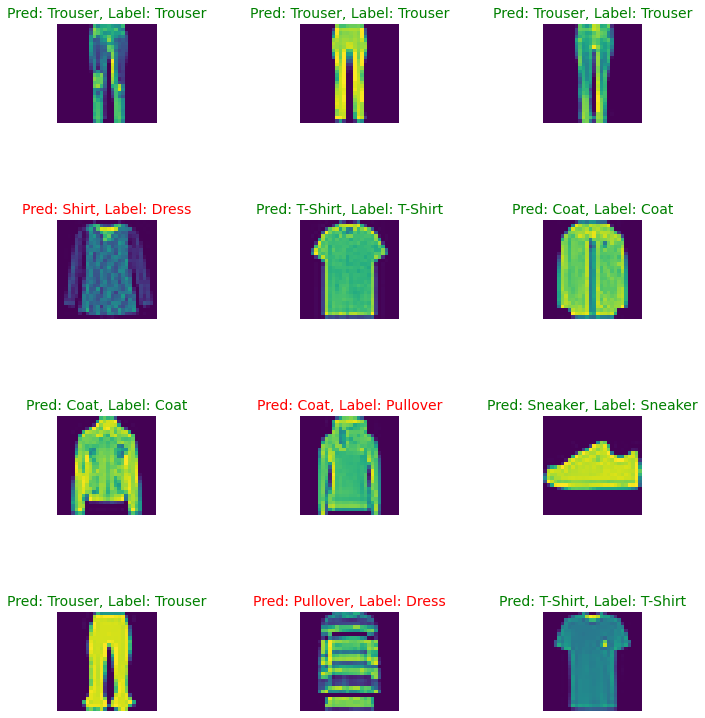

In [7]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(12, 12))
cols, rows = 3, 4

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item() #Generating a random number from the dataset
    img, label = test_data[sample_idx]
    img, label = img.cuda(), label #Moving img Tensor to GPU to load it on the network
    pred = CNN_Model(img[None, ...]).argmax(1) #I've extended the tensor because the network expect a tensor of size 4 ([number of images, Channel, Width, Hight]) and the image sample would only have the last 3

    figure.add_subplot(rows, cols, i)
    plt.title(f"Pred: {labels_map[int(pred)]}, Label: {labels_map[label]}", fontdict={"fontsize": 14, "color": ("green" if labels_map[int(pred)] == labels_map[label] else "red")})
    #plt.title("Label:" + labels_map[label] + ", Pred:" + labels_map[int(pred)]) #Had to turn the pred tensor to integer
    plt.axis("off")
    plt.imshow(img.cpu().squeeze()) #Had to move the tensor to the cpu before squeezing it to visualize it.

figure.tight_layout(pad=8.0)
plt.show()

### Recurrent Neural Networks (RNN)
Traditional feed-forward neural networks take in a fixed amount of input data all at the same time and produce a fixed amount of output each time. On the other hand, RNNs do not consume all the input data at once. Instead, they take them in one at a time and in a sequence. At each step, the RNN does a series of calculations before producing an output. The output, known as the hidden state, is then combined with the next input in the sequence to produce another output. This process continues until the model is programmed to finish or the input sequence ends.

The calculations at each time step consider the context of the previous time steps in the form of the hidden state. Being able to use this contextual information from previous inputs is the key essence to RNNs’ success in sequential problems.

While it may seem that a different RNN cell is being used at each time step in the graphics, the underlying principle of Recurrent Neural Networks is that the RNN cell is actually the exact same one and reused throughout.
#### Long Short Term Memory Networks (LTSMs)
Recurrent Neural Networks can also be divided into units called Long Short Term Memory (LTSM) if there are feedback loops present, or delays of time. In this case, you would have mitigated flow of the input data through the neural network. This allows the neural network to prioritize between what is **important** vs. **non-important** information.
One LTSM is composed of a:
- **Memory cell**: where the input data resides. It’s a container where all the action happens. The gates on its perimeter are able to control what information flows through it and how the input is handled.
- **Input Gate**: This is where the input enters the cell (obviously). There is a tanh activation function because the gate decides whether to let the input data in or erase the present state, and how the input will affect the output. You can see this in the diagram below as it is represented by the middle two activation functions.
- **Output Gate**: This is shown in the diagram by the activation function on the right side. It regulates and filters the output of the function.
- **Forget Gate**: You don’t actually always need the previous input information for the following one. This allows you to rid of information that was previously stored. For example: say you input “Angelica is my friend. Logan is Sam’s cousin.”, then it will ‘forget’ all the data before “friend” by the time it reaches “Logan”. It is seen in the activation function the furthest on the left side.

In general LTSMs are used to classify, identify, or predict output data accordingly based on a series of discrete-time input data. They use gradient descent and back propagation algorithms to minimize error.

In [8]:
class RNN_Classification_Net(nn.Module):
    def __init__(self, device, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(RNN_Classification_Net, self).__init__()
        
        self.device = device
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(n_inputs, n_neurons)
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons).to(device))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.view(-1, 28,28) 
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()

        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output


DEVICE = device
BATCH_SIZE = batch_size
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10

RNN_Model = RNN_Classification_Net(DEVICE,BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS).to(device)
print(RNN_Model)

RNN_Classification_Net(
  (basic_rnn): RNN(28, 150)
  (FC): Linear(in_features=150, out_features=10, bias=True)
)


Now to train the model:

In [9]:
import torch.optim as optim
from torch.utils.data import DataLoader

batch_size = 64
#Loading the data in a dataloader
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

#Implementing both training and testing sets
def train_loop(dataloader, model, loss_fn, optimizer, scheduler):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # reset hidden states
        model.hidden = model.init_hidden()
        
        # Setting up the inputs
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()#reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
        loss.backward()#Backpropagate the prediction loss
        optimizer.step()#adjust the parameters by the gradients collected in the backward pass.

        if batch % 500 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    scheduler.step()


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad(): #Emptying the gradients
        for X, y in dataloader:
            # Setting up the inputs
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

#Defining the Training Parameters
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(RNN_Model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
epochs = 10

#Starting the training and testing
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, RNN_Model, loss_fn, optimizer, scheduler)
    test_loop(test_dataloader, RNN_Model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306526  [    0/60000]
loss: 0.688059  [32000/60000]
Test Error: 
 Accuracy: 71.9%, Avg loss: 0.756336 

Epoch 2
-------------------------------
loss: 0.894215  [    0/60000]
loss: 0.732890  [32000/60000]
Test Error: 
 Accuracy: 80.1%, Avg loss: 0.556672 

Epoch 3
-------------------------------
loss: 0.678330  [    0/60000]
loss: 1.383741  [32000/60000]
Test Error: 
 Accuracy: 79.9%, Avg loss: 0.557623 

Epoch 4
-------------------------------
loss: 0.433267  [    0/60000]
loss: 0.391970  [32000/60000]
Test Error: 
 Accuracy: 79.7%, Avg loss: 0.561119 

Epoch 5
-------------------------------
loss: 0.242465  [    0/60000]
loss: 0.587766  [32000/60000]
Test Error: 
 Accuracy: 83.3%, Avg loss: 0.463344 

Epoch 6
-------------------------------
loss: 0.622533  [    0/60000]
loss: 0.410146  [32000/60000]
Test Error: 
 Accuracy: 83.0%, Avg loss: 0.476951 

Epoch 7
-------------------------------
loss: 0.450098  [    0/60000]
loss: 0.403523  [3

Visualizing the training results:

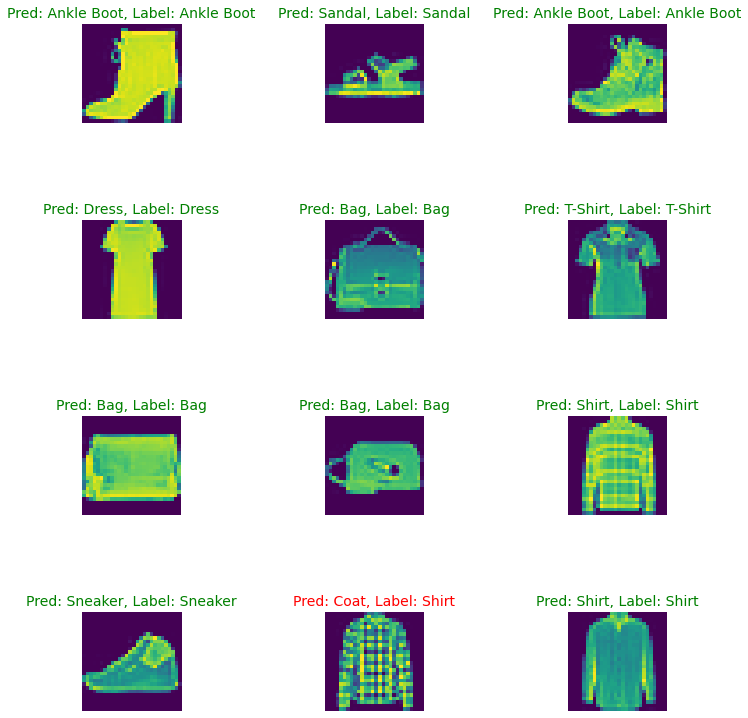

In [10]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(12, 12))
cols, rows = 3, 4

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item() #Generating a random number from the dataset
    img, label = test_data[sample_idx]
    img, label = img.cuda(), label #Moving img Tensor to GPU to load it on the network
    pred = RNN_Model(img[None, ...]).argmax(1) #I've extended the tensor because the network expect a tensor of size 4 ([number of images, Channel, Width, Hight]) and the image sample would only have the last 3

    figure.add_subplot(rows, cols, i)
    plt.title(f"Pred: {labels_map[int(pred)]}, Label: {labels_map[label]}", fontdict={"fontsize": 14, "color": ("green" if labels_map[int(pred)] == labels_map[label] else "red")})
    #plt.title("Label:" + labels_map[label] + ", Pred:" + labels_map[int(pred)]) #Had to turn the pred tensor to integer
    plt.axis("off")
    plt.imshow(img.cpu().squeeze()) #Had to move the tensor to the cpu before squeezing it to visualize it.

figure.tight_layout(pad=8.0)
plt.show()

Saving the model:

In [11]:
import torch

torch.save(RNN_Model, 'Models/Pytorch_Vision/RNN_Model(FashionMNIST).pth')

RNN_Model = torch.load('Models/Pytorch_Vision/RNN_Model(FashionMNIST).pth')
RNN_Model.eval()

RNN_Classification_Net(
  (basic_rnn): RNN(28, 150)
  (FC): Linear(in_features=150, out_features=10, bias=True)
)